In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} for this proj!")

Using device: cuda for this proj!


### RNN:

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, device):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.rnn_layer = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.dense_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, unbatched = False):
        batch_size = x.shape[0]

        if unbatched:
            h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_()
        else:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()

        h0 = h0.to(self.device)

        if unbatched:
          return self.dense_layer(self.rnn_layer(x, h0)[0][-1,:])
        else:
          return self.dense_layer(self.rnn_layer(x, h0)[0][:,-1,:])


### LSTM:

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device):
        super(LSTM, self).__init__() #Calls the constructor of the superclass nn.Module
        self.device = device
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, input: torch.tensor, unbatched: bool = False):
        batch_size = input.shape[0]
        if unbatched:
            h0 = torch.zeros(self.num_layers, self.hidden_dim).requires_grad_()
            c0 = torch.zeros(self.num_layers, self.hidden_dim).requires_grad_()
        else:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()

        h0 = h0.to(self.device)
        c0 = c0.to(self.device)

        out, (hn, c_n) = self.lstm(input, (h0, c0))
        if unbatched:
            out = self.fc(out[-1, :])  # out[-1] will give the hidden state at the last time step
        else:
            out = self.fc(out[:, -1, :])  # out[:, -1, :] will give the hidden state at the last time step for each sequence
        return out

### GRU:

In [ ]:
class GRU(nn.Module):
    def __init__(self, n_features, hidden_size, n_layers, output_size, device):
        super(GRU, self).__init__()
        self.device = device
        self.n_layers = n_layers
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.gru = nn.GRU(n_features,
                          hidden_size=hidden_size,
                          num_layers=n_layers,
                          batch_first=True)

        self.fc1 = nn.Linear(n_features * hidden_size, output_size)

    def forward(self, x, unbatched = False):
        batch_size = x.size(0)
        if unbatched:
            h0 = torch.zeros(self.n_layers, self.hidden_size).to(self.device)
        else:
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)

        out, _ = self.gru(x, h0)
        if unbatched:
            return self.fc1(out[-1,:])
        else:
            return self.fc1(out[:,-1,:])


### Transformer:

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        device = x.device
        encoding = self.encoding.to(device)
        return x + encoding[:, :x.size(1)]

class TransformerModel(nn.Module):
    def __init__(self, num_features, d_model, nhead, num_layers, output_size, max_len=5000):
        super(TransformerModel, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.encoder = nn.Linear(num_features, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers, batch_first=True)
        self.decoder = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.encoder(x)  # Project input to model dimension
        x = self.positional_encoding(x) # Add positional encoding
        x = self.transformer(x, x)
        x = self.decoder(x[:, -1, :])
        return x

In [ ]:
class CNN1D_ForeCastModel(nn.Module):
    def __init__(self, n_features, sequence_length, output_size):
        super(CNN1D_ForeCastModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * (sequence_length // 4), 50)
        self.fc2 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.permute(0,2,1) #CNN expects (batch_size, n_features, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class TimeSeriesDatasetSin(Dataset):
    def __init__(self,x):
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self,i):
        return self.x[i]

### Functions:

In [ ]:
def sin(x, frequency = 0, shift = 0, noise = 0):
        return np.sin(frequency*x+shift) + np.random.rand(len(x)) * noise

def sin_sin(x, frequency = 0, shift = 0, noise = 0):
        return (np.sin(frequency/4 * x+shift)  + 0.5*np.sin(1.5*frequency*x))+0.1*x #+ np.random.rand(len(x)) * noise

### Data preparation:

In [ ]:
def get_sequence(y, sequence_length):
    sequences = []
    for index in range(len(y) - sequence_length):
        sequence = y[index : index + sequence_length]
        sequences.append(sequence)
    return torch.tensor(sequences, dtype = torch.float32)


def make_multistep_dataset(func, num_funcs, sequence_length, sin_sin = False):
    xfl = np.arange(0,100,0.01)
    xtr = xfl[:int(0.8*len(xfl))]
    xts = xfl[int(0.8*len(xfl)):]
    scaler = MinMaxScaler(feature_range=(-1, 1))

    train = []
    test = []

    test_viz = [] #for visualisation of test performance
    for i in range(num_funcs):
        shift = 2 * torch.pi * torch.rand(1).item()
        if sin_sin == True:
          frequency =  15 + (30 * torch.rand(1).item())
        else:
          frequency = 20 * torch.rand(1).item()

        noise = 0.1 * torch.rand(1).item()

        train_data, test_data = scaler.fit_transform(func(xtr, frequency = frequency, shift = shift, noise = noise).reshape(-1,1)), scaler.fit_transform(func(xts, frequency = frequency, shift = shift, noise = noise).reshape(-1,1))
        train_data, test_data = np.squeeze(train_data), np.squeeze(test_data)

        train_sequence = get_sequence(train_data, sequence_length)
        test_sequence = get_sequence(test_data, sequence_length)

        train.append(train_sequence)
        test.append(test_sequence)

        test_viz.append(test_data)

    train, test = torch.cat(train, dim=0).unsqueeze(2), torch.cat(test, dim=0).unsqueeze(2)

    train_dataset = TimeSeriesDatasetSin(train)
    test_dataset = TimeSeriesDatasetSin(test)

    #train loaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, torch.tensor(test_viz, dtype = torch.float32)

### Training and testing:

In [ ]:
def train(model, optimizer, dataloader, num_epochs, loss_func, prediction_horizon: int, rnn: bool):

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_batches = len(dataloader)
        for i, batch in enumerate(
            tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)
        ):
            optimizer.zero_grad()

            x = batch[:, :-prediction_horizon].to(
                device
            )  # All but the last n elements of each sequence
            targets = batch[:, -prediction_horizon:].to(
                device
            )  # Last n elements is targets
            targets = targets.squeeze()  # [batch_size, 1, 1] -> [batch_size]

            outputs = model(x)  # Forward pass
            outputs = outputs.squeeze()  # [batch_size, 1] -> [batch_size]

            loss = loss_func(outputs, targets)

            loss.backward()

            # Gradient clipping
            if rnn == True:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5) #max_grad_norm = 5.

            optimizer.step()

            running_loss += loss.item()

        '''
        # Print gradient values
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient norm: {param.grad.norm().item()}")
        '''
        avg_loss = running_loss / total_batches
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.10f}")


def test(net, forecast_steps, test_loader):
    device = next(net.parameters()).device
    loss_function = nn.MSELoss(reduction = 'mean')
    net.eval()
    with torch.no_grad():
        tot_test_loss = 0.0
        n_batches = len(test_loader)
        for batch in test_loader:
            batch = batch.to(device)

            test_pred = net(batch[:,:-forecast_steps])

            test_loss = loss_function(test_pred, batch[:,-forecast_steps:].squeeze(2))

            tot_test_loss += test_loss.item()
        return tot_test_loss/n_batches

'''
def test_2(net, forecast_steps, test_seq):
    device = next(net.parameters()).device
    loss_function = nn.MSELoss(reduction = 'mean')
    net.eval()
    preds = []
    with torch.no_grad():
        tot_test_loss = 0.0
        n_seq = len(test_seq)
        for i in range(len(test_seq)):
            input_length = len(test_seq[i])-forecast_steps
            input = test_seq[i][0:input_length]
            target = test_seq[i][input_length:input_length + forecast_steps]

            input_tensor = torch.tensor(input).to(device)
            input_tensor = input_tensor.unsqueeze(0)
            test_pred = net(input_tensor).cpu()

            test_loss = loss_function(test_pred.squeeze(0), target.squeeze(1))

            tot_test_loss += test_loss.item()

        return tot_test_loss/n_seq
'''

def forecast(net, ts_viz, sequence_length, forecast_steps, model_type: str, plot=True):
    device = next(net.parameters()).device
    historical_data = ts_viz[:, :sequence_length].unsqueeze(2)
    hist_data_plot = historical_data.squeeze(2).detach().numpy()

    with torch.no_grad():
        historical_data = historical_data.to(device)
        pred = net(historical_data)

    if plot:
        days = np.arange(1, sequence_length + forecast_steps + 1)
        num_plots = len(ts_viz)
        n_rows, n_cols = 2, 3  # Define the grid dimensions
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))
        axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

        for i in range(num_plots):
            vals = ts_viz[i, sequence_length:sequence_length + forecast_steps].cpu().numpy()
            pred_cpu = pred[i].cpu().numpy()  # Move prediction to CPU
            ax = axs[i]
            ax.plot(days[:-forecast_steps], hist_data_plot[i], 'o-', label='Test data')
            ax.plot(days[-forecast_steps:], pred_cpu, 'o-', label='Forecasted values')
            ax.plot(days[-forecast_steps:], vals, '.-', alpha=0.3, label='Actual values', color='tab:blue')
            ax.set_title(f'Forecast of {len(pred[0])} days for {model_type}')
            ax.set_xlabel('Days')
            ax.grid(True)
            if i == 0:
                ax.legend()  # Add legend to the first plot only to avoid clutter

        # Hide any unused subplots
        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axs[j])

        plt.tight_layout()
        plt.savefig(f'{model_type}')
        plt.show()


### Normal sine-functions:

In [ ]:
#hyperparameters for transformer
num_features = 1
d_model = 64
nhead = 4
num_layers_transformer = 2

#hyperparameters for rnns
forecast_steps = 50
sequence_length = 100
num_funcs = 6

input_size = 1
hidden_size = 512
output_size = forecast_steps
num_layers = 1

transformer_model = TransformerModel(num_features, d_model, nhead, num_layers_transformer, output_size).to(device)
rnn_model = RNN(input_size, hidden_size, num_layers, output_size, device).to(device)
lstm_model = LSTM(input_size, hidden_size, num_layers, output_size, device).to(device)
gru_model = GRU(input_size, hidden_size, num_layers, output_size, device).to(device)
cnn_model = CNN1D_ForeCastModel(num_features, sequence_length, output_size).to(device)

'''models = {'Transformer': transformer_model, 'RNN': rnn_model, 'GRU': gru_model, 'LSTM': lstm_model, 'CNN': cnn_model}
optimizers = {
    'Transformer': optim.SGD(transformer_model.parameters(), lr=0.1),
    'RNN' : optim.SGD(rnn_model.parameters(), lr=0.1),
    'LSTM': optim.SGD(lstm_model.parameters(), lr=0.1),
    'GRU': optim.SGD(gru_model.parameters(), lr=0.1),
    'CNN': optim.SGD(cnn_model.parameters(), lr=0.1)
}'''

models = {'CNN': cnn_model}
optimizers = {
    'CNN': optim.SGD(cnn_model.parameters(), lr=0.1)
}
loss_function = nn.MSELoss(reduction = 'mean')

trloader_sin, tsloader_sin, ts_viz = make_multistep_dataset(sin, num_funcs, sequence_length+forecast_steps)

#train all models
for model in models.keys():
    rnn = False
    print(f'Training {model}: ')
    if model == 'RNN':
        rnn = True
    train(models[model], optimizers[model], trloader_sin, num_epochs=10, loss_func=loss_function, prediction_horizon=forecast_steps, rnn = rnn)
    print('----------------------------------------------')
#plot of forecast

for model in models.keys():
    forecast(models[model], ts_viz, sequence_length, forecast_steps, f'{model}')

#train(rnn_sin, optimizer, trloader_sin, num_epochs=10, loss_func=loss_function, prediction_horizon=forecast_steps, max_grad_norm=5)

Training CNN: 


Epoch 1/10: 100%|██████████████████████████████████████████████| 2944/2944 [00:07<00:00, 385.64it/s]


Epoch 1/10, Average Loss: 0.0521509245


Epoch 2/10: 100%|██████████████████████████████████████████████| 2944/2944 [00:06<00:00, 461.27it/s]


Epoch 2/10, Average Loss: 0.0113246810


Epoch 3/10: 100%|██████████████████████████████████████████████| 2944/2944 [00:06<00:00, 453.56it/s]


Epoch 3/10, Average Loss: 0.0059974734


Epoch 4/10: 100%|██████████████████████████████████████████████| 2944/2944 [00:06<00:00, 463.04it/s]


Epoch 4/10, Average Loss: 0.0029748958


Epoch 5/10: 100%|██████████████████████████████████████████████| 2944/2944 [00:06<00:00, 441.94it/s]


Epoch 5/10, Average Loss: 0.0019436719


Epoch 6/10: 100%|██████████████████████████████████████████████| 2944/2944 [00:06<00:00, 480.05it/s]


Epoch 6/10, Average Loss: 0.0014499120


Epoch 7/10: 100%|██████████████████████████████████████████████| 2944/2944 [00:06<00:00, 445.43it/s]


Epoch 7/10, Average Loss: 0.0012416457


Epoch 8/10: 100%|██████████████████████████████████████████████| 2944/2944 [00:06<00:00, 480.09it/s]


Epoch 8/10, Average Loss: 0.0010956957


Epoch 9/10: 100%|██████████████████████████████████████████████| 2944/2944 [00:07<00:00, 399.01it/s]


Epoch 9/10, Average Loss: 0.0009944323


Epoch 10/10: 100%|█████████████████████████████████████████████| 2944/2944 [00:06<00:00, 484.13it/s]

Epoch 10/10, Average Loss: 0.0009286617
----------------------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x1184 and 800x50)

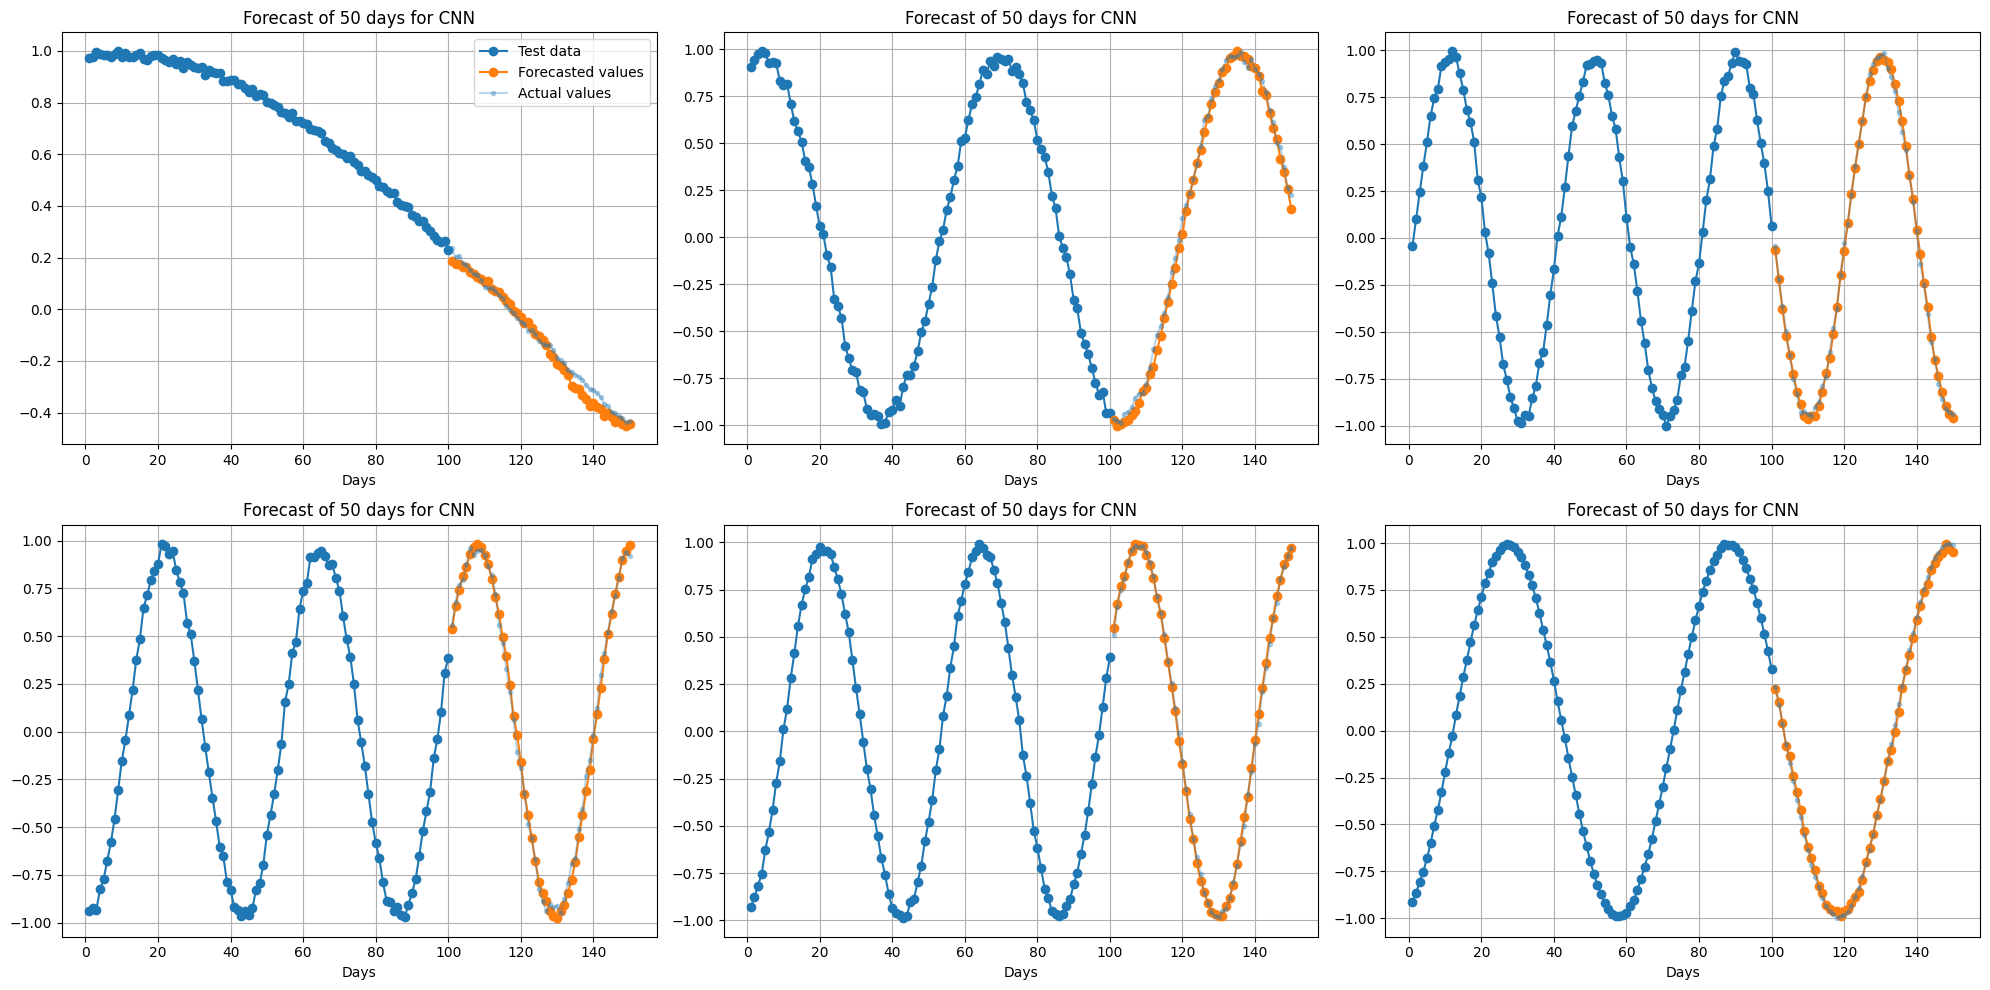

In [ ]:
for model in models.keys():
    forecast(models[model], ts_viz, sequence_length, forecast_steps, f'{model}')

In [ ]:
'''
forecast_steps = 20
sequence_length = 30 + forecast_steps
num_funcs = 1

input_size = 1
hidden_size = 50 #400
output_size = forecast_steps
num_layers = 1

trloader_sin, tsloader_sin, ts, ts_viz = make_multistep_dataset(sin, num_funcs, sequence_length)

rnn_sin = RNN(input_size, hidden_size, num_layers, output_size).to(device)
optimizer = optim.SGD(rnn_sin.parameters(), lr = 0.1)
loss_function = nn.MSELoss(reduction = 'mean')
'''

Had a problem with exploding/vanishing gradients so I had to tune the parameters. Got nan/inf values for some runs. Hidden_size, sequence length too big is the main problem.

### More advanced sin-functions:

<ipython-input-10-f740e48542c3>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(sequences, dtype = torch.float32)


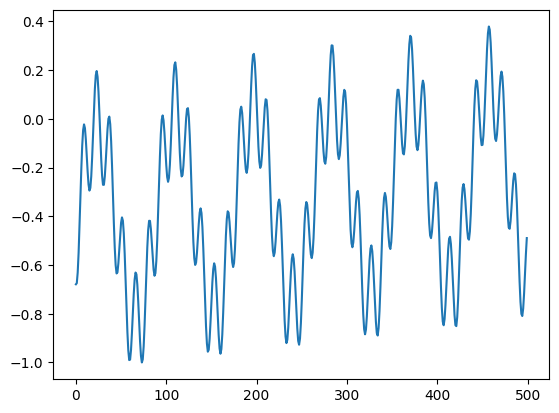

In [ ]:
#hyperparameters for transformer
num_features = 1
d_model = 64
nhead = 4
num_layers_transformer = 3

#hyperparameters for rnns
forecast_steps = 50
sequence_length = 200
num_funcs = 6

input_size = 1
hidden_size = 512
output_size = forecast_steps
num_layers = 1

transformer_model_adv = TransformerModel(num_features, d_model, nhead, num_layers_transformer, output_size).to(device)
rnn_model_adv = RNN(input_size, hidden_size, num_layers, output_size, device).to(device)
lstm_model_adv = LSTM(input_size, hidden_size, num_layers, output_size, device).to(device)
gru_model_adv = GRU(input_size, hidden_size, num_layers, output_size, device).to(device)
cnn_model_adv = CNN1D_ForeCastModel(num_features, sequence_length, output_size).to(device)

models_adv = {'Transformer': transformer_model_adv, 'RNN': rnn_model_adv, 'GRU': gru_model_adv, 'LSTM': lstm_model_adv, 'CNN': cnn_model_adv}
optimizers_adv = {
    'Transformer': optim.SGD(transformer_model_adv.parameters(), lr=0.1),
    'RNN' : optim.SGD(rnn_model_adv.parameters(), lr=0.1),
    'LSTM': optim.SGD(lstm_model_adv.parameters(), lr=0.1),
    'GRU': optim.SGD(gru_model_adv.parameters(), lr=0.1),
    'CNN': optim.SGD(cnn_model_adv.parameters(), lr=0.1)
}
loss_function = nn.MSELoss(reduction = 'mean')
trloader_adv, tsloader_adv, ts_viz_adv = make_multistep_dataset(sin_sin, num_funcs, sequence_length+forecast_steps, sin_sin = True)
plt.plot(ts_viz_adv[0][:500])
plt.show()


In [ ]:
#train all models
for model in models_adv.keys():
    rnn = False
    print(f'Training {model}: ')
    if model == 'RNN':
        rnn = True
    train(models_adv[model], optimizers_adv[model], trloader_adv, num_epochs=10, loss_func=loss_function, prediction_horizon=forecast_steps, rnn = rnn)
    print('----------------------------------------------')

Training Transformer: 


Epoch 1/10: 100%|███████████████████████████████████████████████| 2907/2907 [01:40<00:00, 28.90it/s]


Epoch 1/10, Average Loss: 0.0275080243


Epoch 2/10: 100%|███████████████████████████████████████████████| 2907/2907 [01:39<00:00, 29.20it/s]


Epoch 2/10, Average Loss: 0.0137615713


Epoch 3/10: 100%|███████████████████████████████████████████████| 2907/2907 [01:39<00:00, 29.15it/s]


Epoch 3/10, Average Loss: 0.0085311772


Epoch 4/10: 100%|███████████████████████████████████████████████| 2907/2907 [01:39<00:00, 29.15it/s]


Epoch 4/10, Average Loss: 0.0070472252


Epoch 5/10: 100%|███████████████████████████████████████████████| 2907/2907 [01:41<00:00, 28.55it/s]


Epoch 5/10, Average Loss: 0.0062769142


Epoch 6/10: 100%|███████████████████████████████████████████████| 2907/2907 [01:40<00:00, 28.97it/s]


Epoch 6/10, Average Loss: 0.0057016929


Epoch 7/10: 100%|███████████████████████████████████████████████| 2907/2907 [01:39<00:00, 29.19it/s]


Epoch 7/10, Average Loss: 0.0051835736


Epoch 8/10: 100%|███████████████████████████████████████████████| 2907/2907 [01:39<00:00, 29.19it/s]


Epoch 8/10, Average Loss: 0.0045817091


Epoch 9/10: 100%|███████████████████████████████████████████████| 2907/2907 [01:39<00:00, 29.20it/s]


Epoch 9/10, Average Loss: 0.0039677855


Epoch 10/10: 100%|██████████████████████████████████████████████| 2907/2907 [01:40<00:00, 28.99it/s]


Epoch 10/10, Average Loss: 0.0033675961
----------------------------------------------
Training RNN: 


Epoch 1/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:26<00:00, 109.25it/s]


Epoch 1/10, Average Loss: 0.0430382885


Epoch 2/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:25<00:00, 113.43it/s]


Epoch 2/10, Average Loss: 0.0621874454


Epoch 3/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:25<00:00, 112.98it/s]


Epoch 3/10, Average Loss: 0.0430031619


Epoch 4/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:25<00:00, 113.46it/s]


Epoch 4/10, Average Loss: 0.0389462567


Epoch 5/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:26<00:00, 111.45it/s]


Epoch 5/10, Average Loss: 0.0511893297


Epoch 6/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:26<00:00, 111.36it/s]


Epoch 6/10, Average Loss: 0.0456048344


Epoch 7/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:25<00:00, 113.18it/s]


Epoch 7/10, Average Loss: 0.0363556578


Epoch 8/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:25<00:00, 113.04it/s]


Epoch 8/10, Average Loss: 0.0401917948


Epoch 9/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:25<00:00, 113.36it/s]


Epoch 9/10, Average Loss: 0.0380015086


Epoch 10/10: 100%|█████████████████████████████████████████████| 2907/2907 [00:25<00:00, 113.28it/s]


Epoch 10/10, Average Loss: 0.0421304542
----------------------------------------------
Training GRU: 


Epoch 1/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:44<00:00, 64.81it/s]


Epoch 1/10, Average Loss: 0.0476659739


Epoch 2/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:45<00:00, 64.46it/s]


Epoch 2/10, Average Loss: 0.0294683747


Epoch 3/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:44<00:00, 64.78it/s]


Epoch 3/10, Average Loss: 0.0273758087


Epoch 4/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:44<00:00, 64.79it/s]


Epoch 4/10, Average Loss: 0.0266374786


Epoch 5/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:44<00:00, 64.71it/s]


Epoch 5/10, Average Loss: 0.0248402205


Epoch 6/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:44<00:00, 64.69it/s]


Epoch 6/10, Average Loss: 0.0194485196


Epoch 7/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:44<00:00, 64.68it/s]


Epoch 7/10, Average Loss: 0.0169355169


Epoch 8/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:44<00:00, 64.78it/s]


Epoch 8/10, Average Loss: 0.0157735957


Epoch 9/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:44<00:00, 64.62it/s]


Epoch 9/10, Average Loss: 0.0141218112


Epoch 10/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:44<00:00, 64.64it/s]


Epoch 10/10, Average Loss: 0.0135430488
----------------------------------------------
Training LSTM: 


Epoch 1/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.43it/s]


Epoch 1/10, Average Loss: 0.0603835428


Epoch 2/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.45it/s]


Epoch 2/10, Average Loss: 0.0327865570


Epoch 3/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.44it/s]


Epoch 3/10, Average Loss: 0.0298762452


Epoch 4/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.47it/s]


Epoch 4/10, Average Loss: 0.0264978008


Epoch 5/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.45it/s]


Epoch 5/10, Average Loss: 0.0244547734


Epoch 6/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.42it/s]


Epoch 6/10, Average Loss: 0.0236991285


Epoch 7/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.42it/s]


Epoch 7/10, Average Loss: 0.0200599997


Epoch 8/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.38it/s]


Epoch 8/10, Average Loss: 0.0161409800


Epoch 9/10: 100%|███████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.38it/s]


Epoch 9/10, Average Loss: 0.0142443773


Epoch 10/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:58<00:00, 49.42it/s]


Epoch 10/10, Average Loss: 0.0127954006
----------------------------------------------
Training CNN: 


Epoch 1/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:07<00:00, 398.72it/s]


Epoch 1/10, Average Loss: 0.0155166184


Epoch 2/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:06<00:00, 479.15it/s]


Epoch 2/10, Average Loss: 0.0051992446


Epoch 3/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:06<00:00, 440.69it/s]


Epoch 3/10, Average Loss: 0.0038350774


Epoch 4/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:06<00:00, 477.90it/s]


Epoch 4/10, Average Loss: 0.0026208723


Epoch 5/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:06<00:00, 433.96it/s]


Epoch 5/10, Average Loss: 0.0017807600


Epoch 6/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:06<00:00, 475.94it/s]


Epoch 6/10, Average Loss: 0.0013359921


Epoch 7/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:06<00:00, 439.53it/s]


Epoch 7/10, Average Loss: 0.0010201738


Epoch 8/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:06<00:00, 470.88it/s]


Epoch 8/10, Average Loss: 0.0008202933


Epoch 9/10: 100%|██████████████████████████████████████████████| 2907/2907 [00:06<00:00, 435.43it/s]


Epoch 9/10, Average Loss: 0.0006853951


Epoch 10/10: 100%|█████████████████████████████████████████████| 2907/2907 [00:06<00:00, 481.74it/s]

Epoch 10/10, Average Loss: 0.0005782091
----------------------------------------------


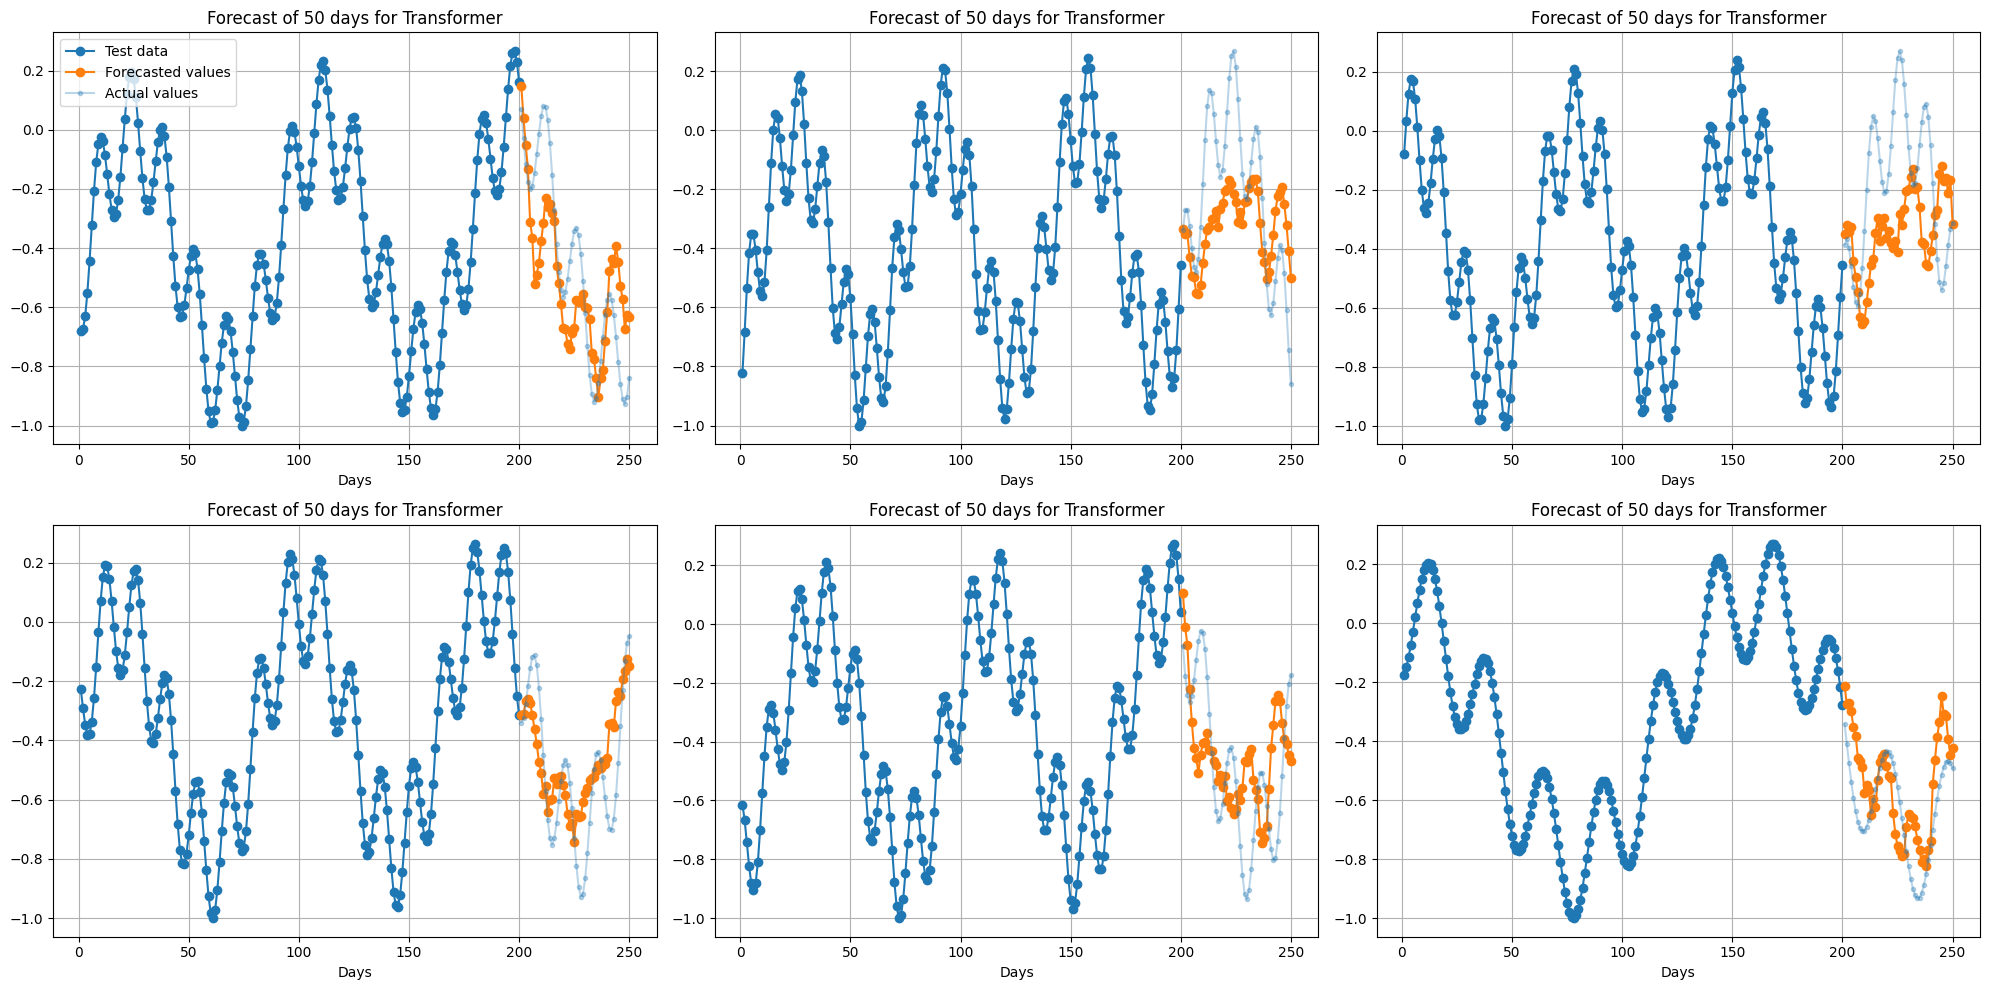

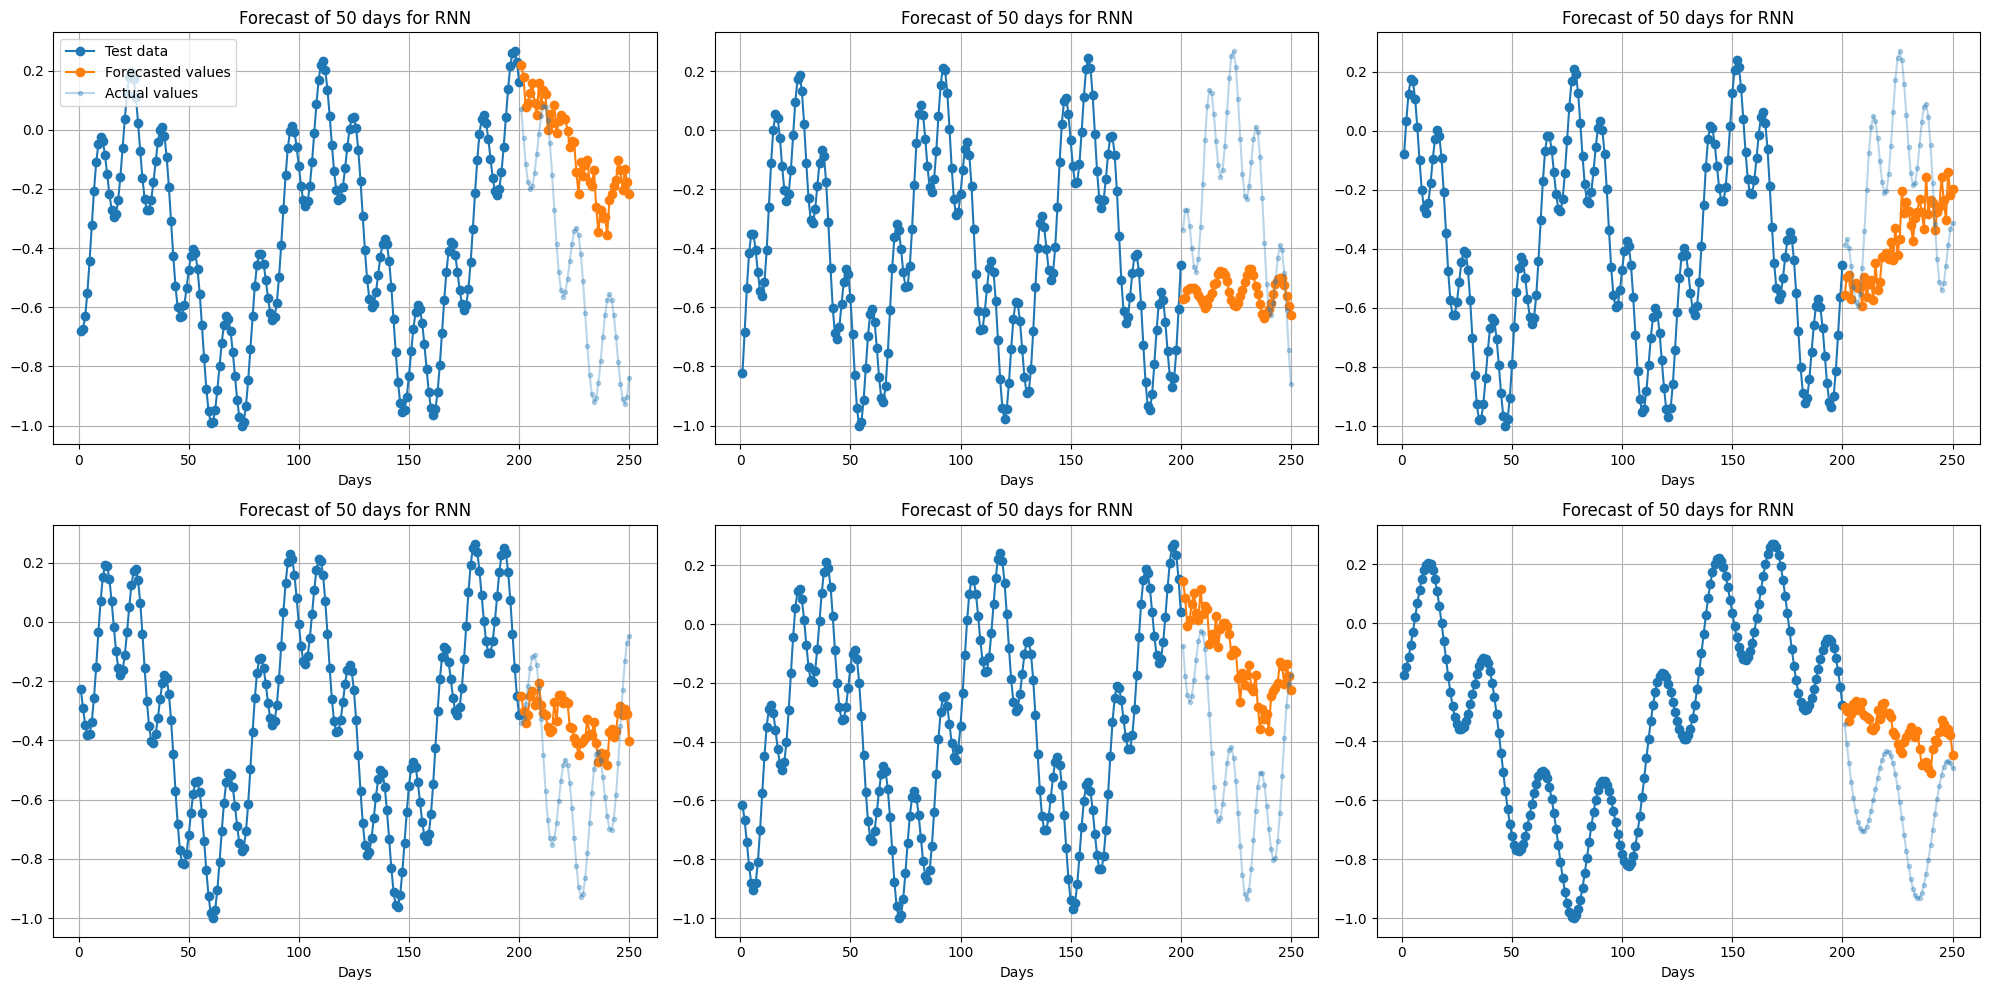

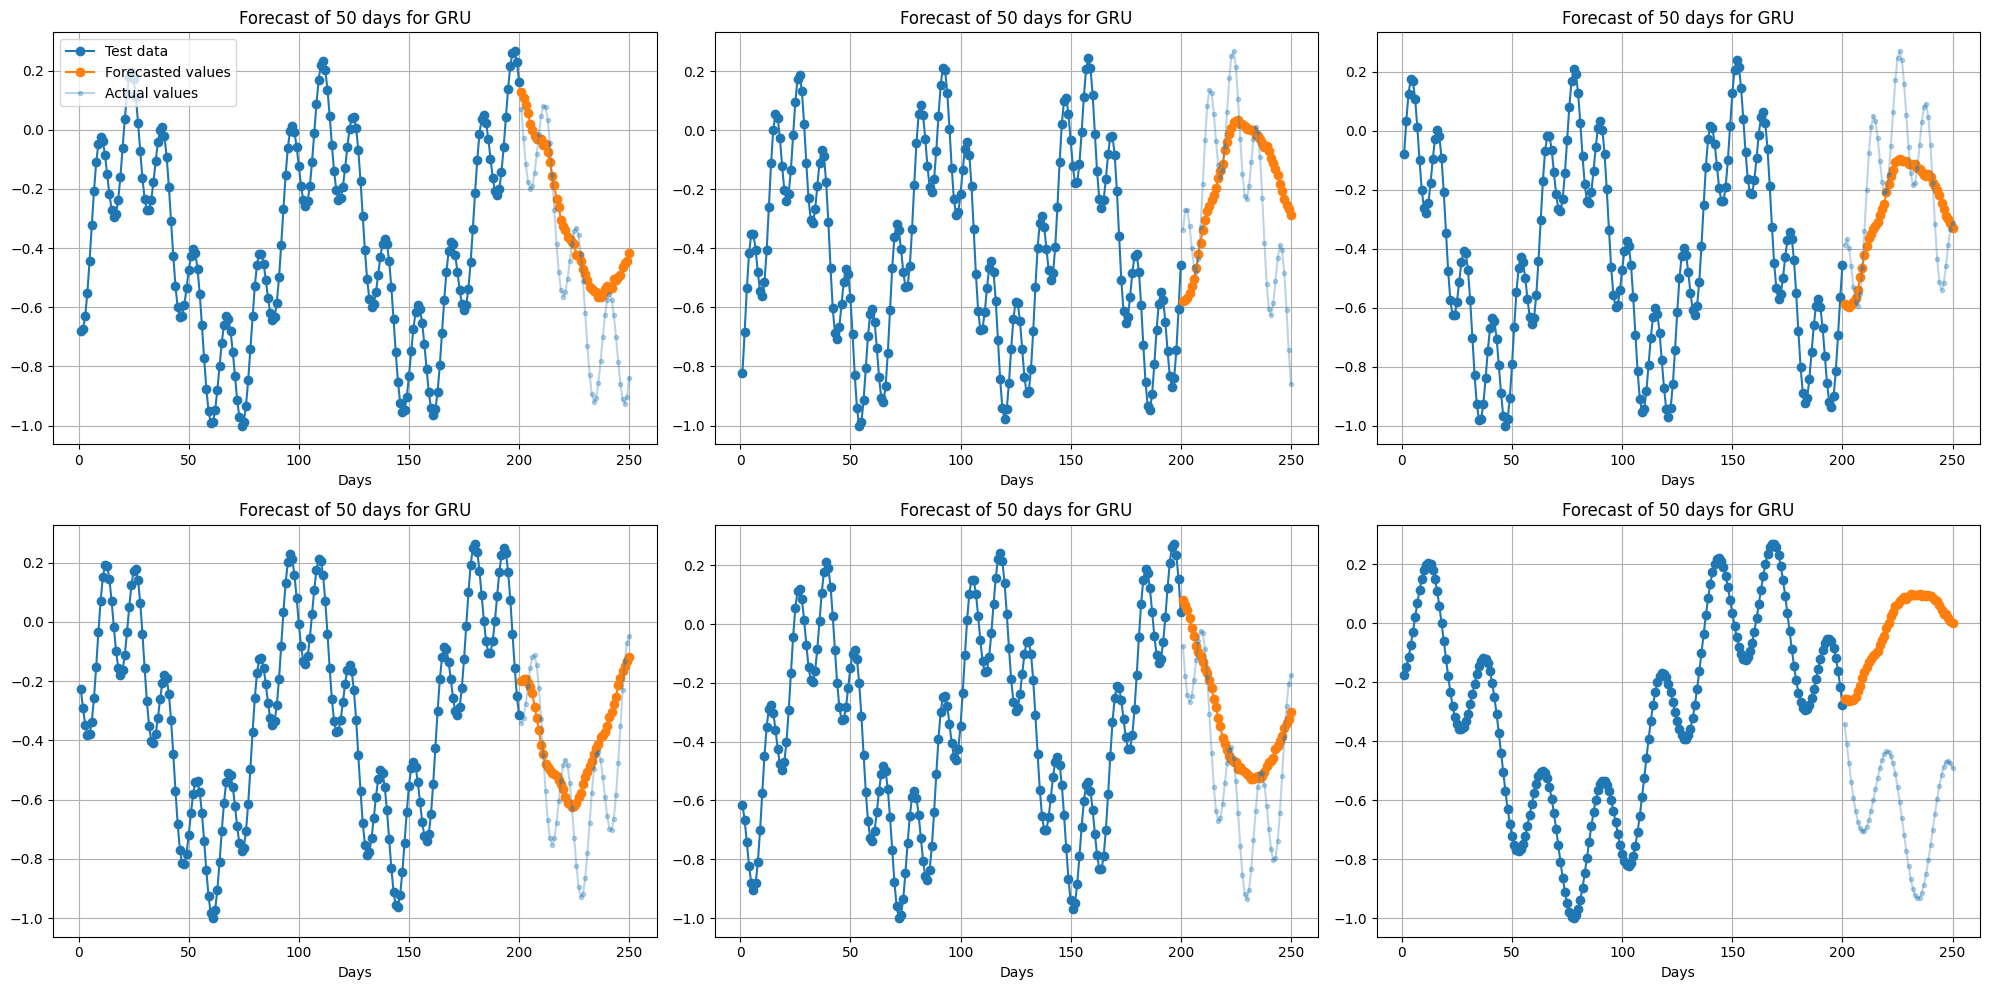

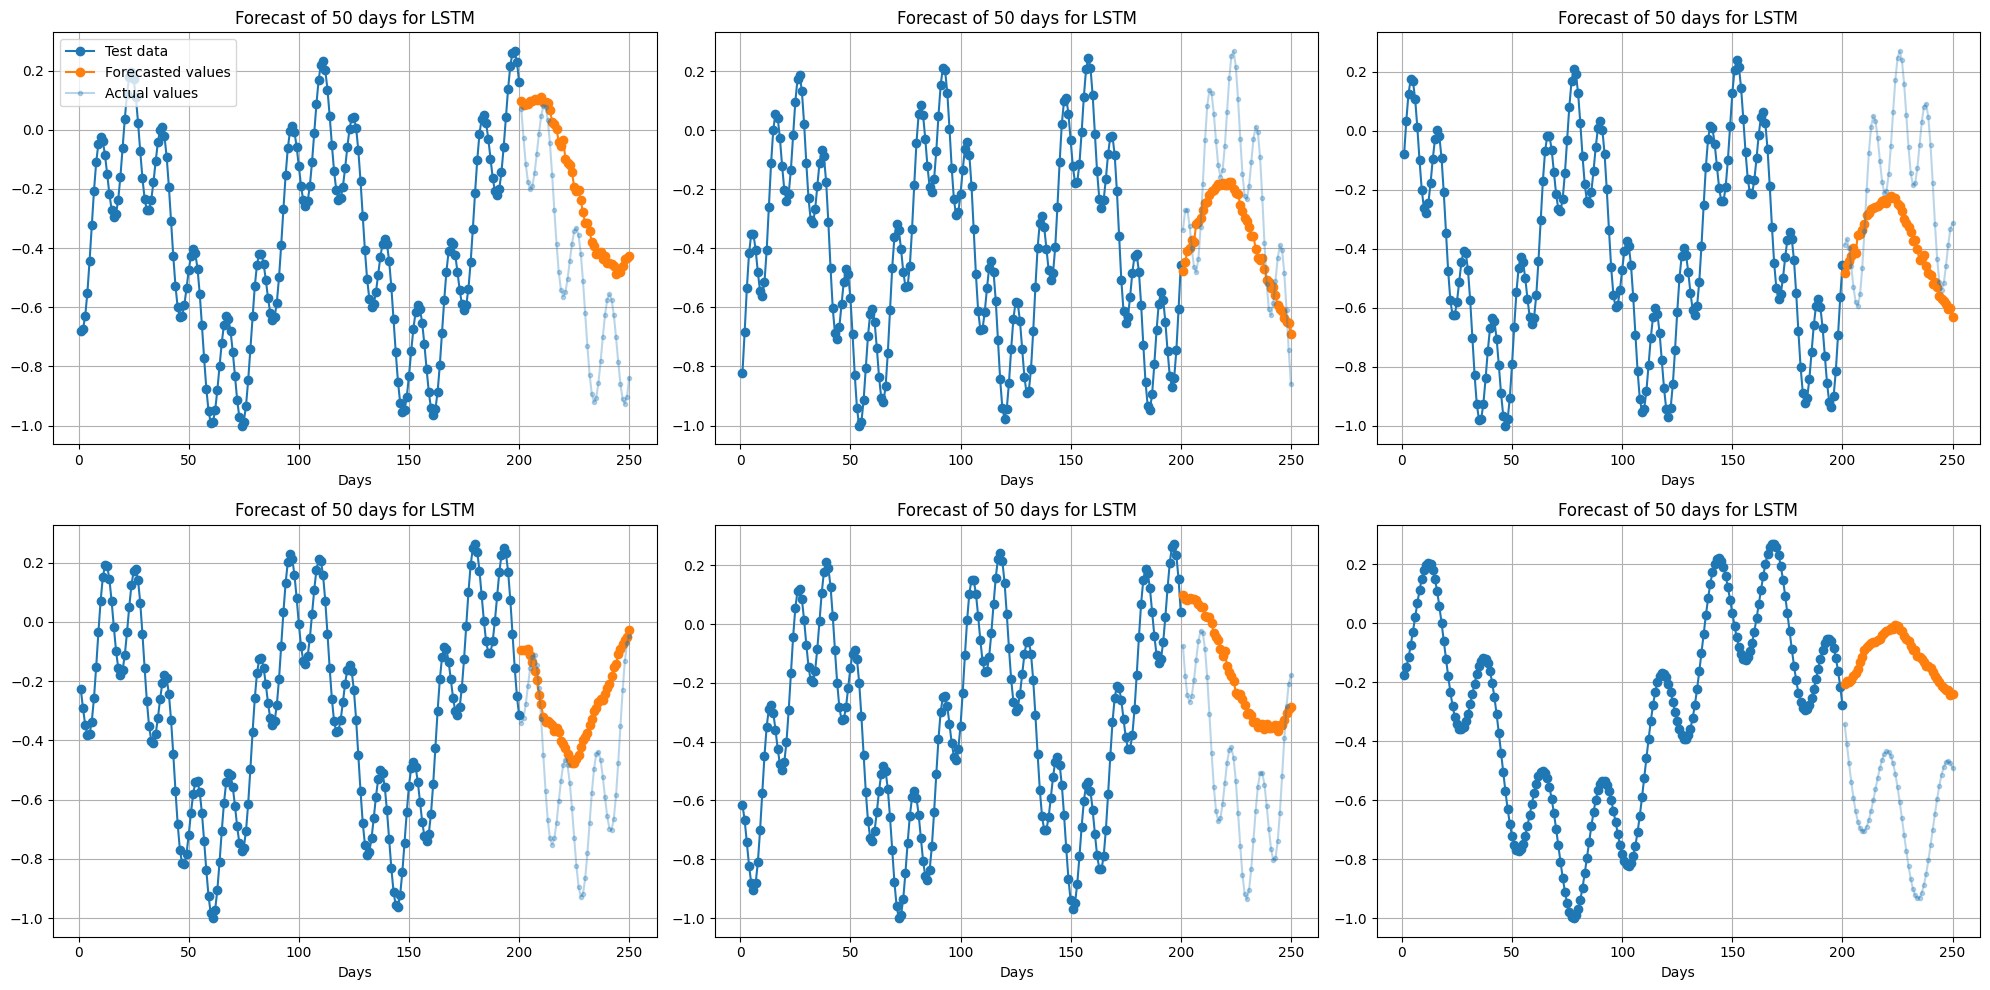

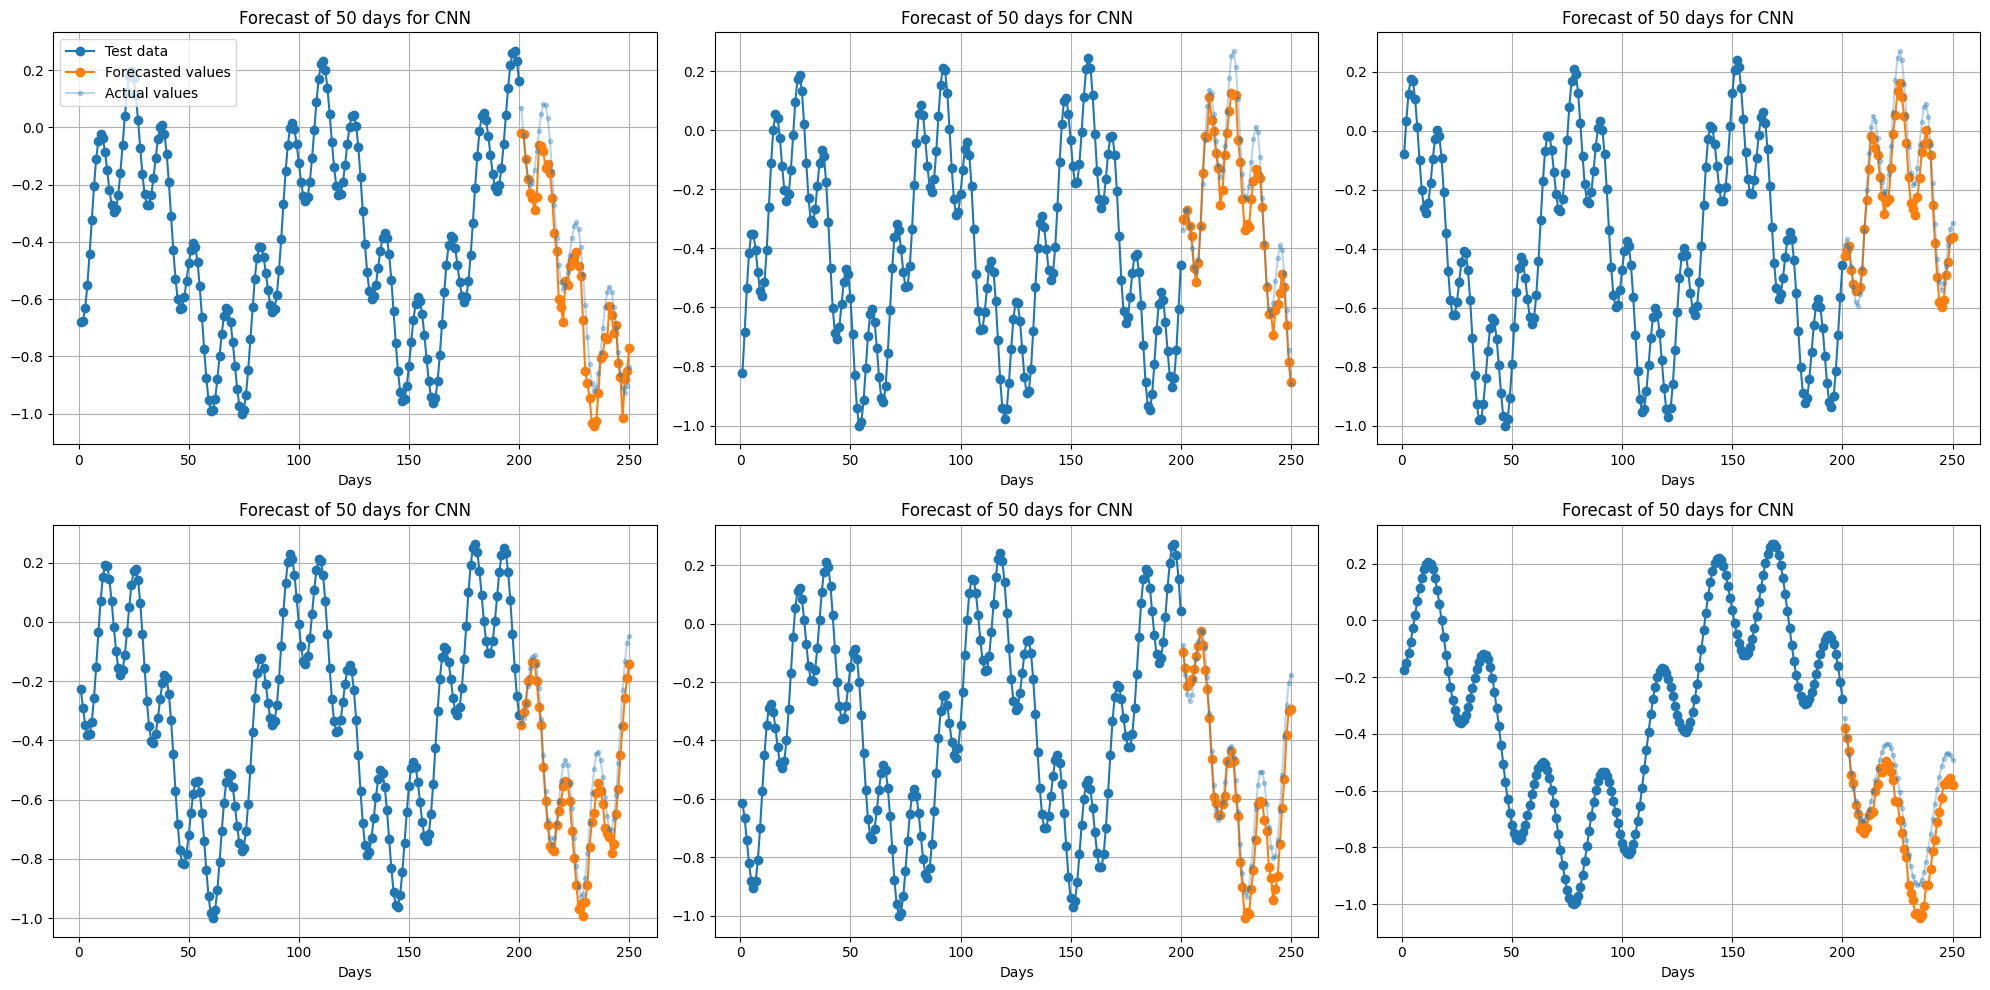

In [ ]:

#plot of forecast
for model in models_adv.keys():
    forecast(models_adv[model], ts_viz_adv, sequence_length, forecast_steps, f'{model}')

In [ ]:
def calculate_sample_entropy(time_series, m: int = 2, r: float = 0.2): #returns a float between 0 and 1 representing how "random" a timeseries is.
    N = len(time_series)
    r = np.std(time_series)
    A = 0
    B = 0

    for i in range(N - m): #all possible window staring points in the series
        template_im = time_series[i:i + m]
        template_im1 = time_series[i:i + m + 1]

        for j in range(N - m): #comparing to all other windows
            if i != j:
                template_jm = time_series[j:j + m]
                template_jm1 = time_series[j:j + m + 1]

                if np.max(np.abs(template_im - template_jm)) < r:
                    A += 1

                    if np.max(np.abs(template_im1 - template_jm1)) < r:
                        B += 1

    if A == 0 or B == 0:
        return float('inf')

    similarity_ratio = B/A
    return -np.log(similarity_ratio)

In [ ]:

calculate_sample_entropy(ts_viz_adv[2][:1000].numpy())

0.13294140051822442